#Import the Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


#Define the parameters

In [ ]:
##Parameters
B 		= 128    	#batch size
N 		= 300		#timesteps
S 		= 3		 	#number of species
dt 		= 0.01		#time interval
L1 		= 0.02 		#L1 regularization parameter

#Training

##Data placeholders

In [ ]:
input_ 		= tf.placeholder(tf.float32, shape=[N, B, S])
output_ 	= tf.placeholder(tf.float32, shape=[B])
initial_ 	= tf.placeholder(tf.float32, shape=[B, S])

##Define variables

In [ ]:
W = tf.Variable(tf.random_normal([S,S], mean = 0, stddev = 0.1, dtype = tf.float32))
A = tf.Variable(1.0, dtype = tf.float32)

##Non-Lineraity Function

In [ ]:
##Nonlinearity chosen
def phi(x):
	return 1/(tf.exp(-x)+1)

##ODE Function

In [ ]:
##ODE function
def simulate(input_, initial_, W):
	output = tf.scan(lambda o,i: o + dt*(phi(tf.matmul(o,W))-o+i),
							elems = input_,
							initializer = initial_,
							swap_memory = True)
	return output


output = simulate(input_, initial_, W)

##Train the function

In [ ]:
## Training function
relevantOutput 	= A*output[N-1,:,1]
## Without regularization
cost = tf.reduce_mean(tf.square(((relevantOutput - output_))))
train_step = tf.train.AdamOptimizer(learning_rate=0.2, beta1=0.98, beta2=0.999, epsilon=1e-08).minimize(cost)
## With regularization
costL1 = tf.reduce_mean(tf.square(((relevantOutput - output_)))) + L1*tf.reduce_mean(tf.abs(W))
train_stepL1 = tf.train.AdamOptimizer(learning_rate=0.2, beta1=0.98, beta2=0.999, epsilon=1e-08).minimize(costL1)

#French-Flag Circuit

In [ ]:
## Training data - here for a "stripe"
def newBatch(plot=False):
	initialVal		= 0.1*np.ones([B,S])
	if(plot):
		inputNoNoise = np.linspace(0,2,B)
	else:
		inputNoNoise    = np.random.uniform(0,2,B)
	inputVal		= inputNoNoise.reshape(B,1) * np.random.normal(loc=1.0, scale = 0.0001, size=[N,B,S])
	inputVal[:,:,1:S] = 0.0
	outputNoNoise  	= np.zeros_like(inputNoNoise)
	outputNoNoise[np.logical_and(inputNoNoise > 0.5,inputNoNoise < 1.5 )] = 1.0
	return [inputVal, outputNoNoise, initialVal]

In [ ]:
## Training model function
def trainModel(iterations,regularize=False,prune=False,pruneLimit=1,printing=False):
	mask = np.abs(sess.run(W)) > pruneLimit
	for i in range(iterations):
		[inputVal, outputVal, initialVal] = newBatch()
		if(regularize):
			sess.run(train_stepL1, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
		else:
			sess.run(train_step, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
		if(printing):
			ww = sess.run(cost, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
			print([ww, i])
		if(prune):
			applyMask = W.assign(W*mask)
			sess.run(applyMask)

##Simulate the model

In [ ]:
def simulateModel():
	[inputVal, outputVal, initialVal] = newBatch(plot=True)
	finalOutput = sess.run(relevantOutput, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
	weights = sess.run(W)
	print(weights)
	plt.plot(finalOutput)
	plt.show()

#Train Vanilla Network

[[-15.084726   -3.8150778 -16.763454 ]
 [-19.546625   13.223277    4.9031396]
 [-21.29405    -9.324241   11.958691 ]]


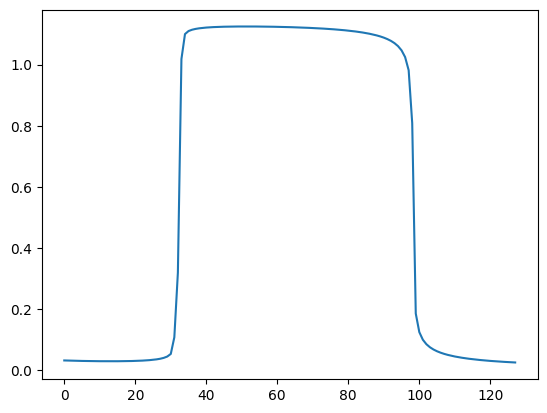

In [ ]:
## Train model

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
trainModel(iterations=2000)
simulateModel()

#Train regularised Network

[[-1.3394367e+00 -2.2514699e+00 -5.2696414e+00]
 [-6.1989300e-02  9.3352098e+00  1.4993412e+00]
 [ 6.2283976e-03 -5.5784645e+00  6.8796911e+00]]


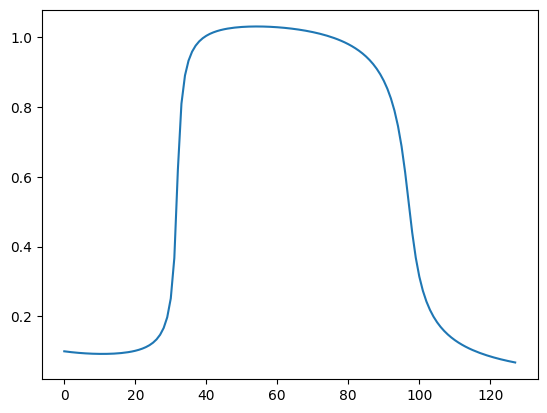

In [ ]:
trainModel(iterations=1000, regularize=True)
simulateModel()

#Train Pruned Network

[[ -5.4916077  -3.0409937 -10.439149 ]
 [  0.         11.045034    3.6218123]
 [  0.         -7.5425506   9.877682 ]]


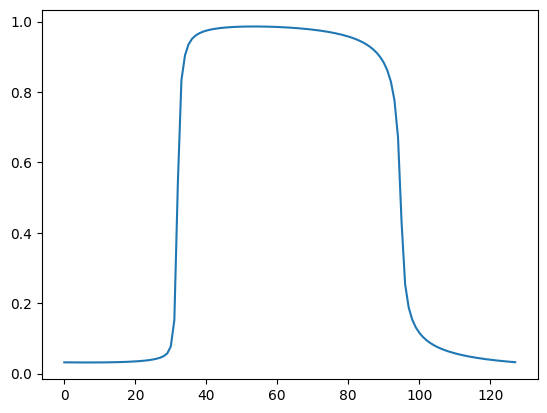

In [ ]:
trainModel(iterations=1000, prune=True)
simulateModel()

#Switch Circuit

In [ ]:
## Training data - here for a "switch"
def newBatchswitch(plot=False):
	initialVal		= 0.1*np.ones([B,S])
	if(plot):
		inputNoNoise = np.linspace(0,2,B)
	else:
		inputNoNoise    = np.random.uniform(0,2,B)
	inputVal		= inputNoNoise.reshape(B,1) * np.random.normal(loc=1.0, scale = 0.0001, size=[N,B,S])
	inputVal[:,:,1:S] = 0.0
	outputNoNoise  	= np.zeros_like(inputNoNoise)
	outputNoNoise[np.logical_and(inputNoNoise > 1.0, inputNoNoise<2.0)] = 1.0
	return [inputVal, outputNoNoise, initialVal]

In [ ]:
## Training model function
def trainModelswitch(iterations,regularize=False,prune=False,pruneLimit=1,printing=False):
	mask = np.abs(sess.run(W)) > pruneLimit
	for i in range(iterations):
		[inputVal, outputVal, initialVal] = newBatchswitch()
		if(regularize):
			sess.run(train_stepL1, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
		else:
			sess.run(train_step, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
		if(printing):
			ww = sess.run(cost, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
			print([ww, i])
		if(prune):
			applyMask = W.assign(W*mask)
			sess.run(applyMask)

##Simulate the model

In [ ]:
def simulateModelswitch():
	[inputVal, outputVal, initialVal] = newBatchswitch(plot=True)
	finalOutput = sess.run(relevantOutput, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
	weights = sess.run(W)
	print(weights)
	plt.plot(finalOutput)
	plt.show()

##Train Vanilla Network

[[ -8.213452     0.10115886 -11.967898  ]
 [ -4.3596287   11.323807     3.5634944 ]
 [ -4.4018207  -10.046391    16.758833  ]]


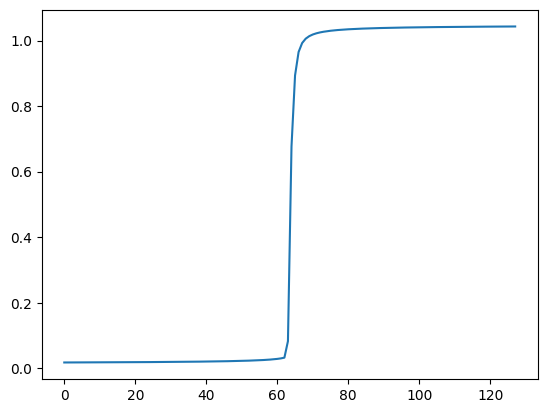

In [ ]:
## Train model

sess_switch = tf.InteractiveSession()
tf.global_variables_initializer().run()
trainModelswitch(iterations=2000)
simulateModelswitch()

##Train regularised Network

[[-2.7583638e-01 -6.6445256e-04 -4.5995321e+00]
 [-4.5559321e-02  3.3239603e+00  3.7401818e-02]
 [-7.2428174e-02 -4.4255552e+00  1.1082960e+01]]


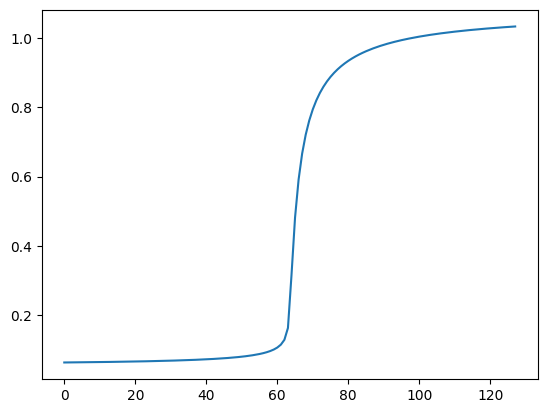

In [ ]:
trainModelswitch(iterations=1000, regularize=True)
simulateModelswitch()

##Train Pruned Network

[[ 0.         0.        -6.1608777]
 [ 0.         6.9768314 -0.       ]
 [ 0.        -7.277479  14.047228 ]]


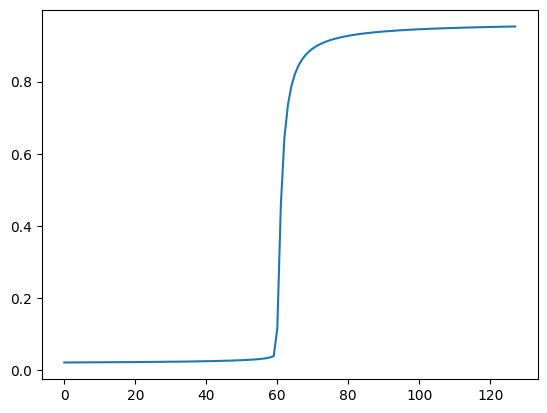

In [ ]:
trainModelswitch(iterations=1000, prune=True)
simulateModelswitch()

#Duration Network Circuit

In [ ]:
## Training data - here for a "switch"
def newBatchduration(plot=False):
	initialVal		= 0.1*np.ones([B,S])
	if(plot):
		inputNoNoise = np.linspace(0,2,B)
	else:
		del_t = np.random.uniform(0,1/3,B)
		if(np.logical_and(t>1/6, t<(1/6+del_t))):
			inputNoNoise = 1
		else:
			inputNoNoise = 0
	inputVal		= inputNoNoise.reshape(B,1) * np.random.normal(loc=1.0, scale = 0.0001, size=[N,B,S])
	inputVal[:,:,1:S] = 0.0
	outputNoNoise  	= np.zeros_like(inputNoNoise)
	outputNoNoise[np.logical_and(del_t > 1/6, del_t<1/3)] = 1.0
	return [inputVal, outputNoNoise, initialVal]

In [ ]:
## Training model function
def trainModelduration(iterations,regularize=False,prune=False,pruneLimit=1,printing=False):
	mask = np.abs(sess.run(W)) > pruneLimit
	for i in range(iterations):
		[inputVal, outputVal, initialVal] = newBatchduration()
		if(regularize):
			sess.run(train_stepL1, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
		else:
			sess.run(train_step, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
		if(printing):
			ww = sess.run(cost, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
			print([ww, i])
		if(prune):
			applyMask = W.assign(W*mask)
			sess.run(applyMask)

##Simulate the model

In [ ]:
def simulateModelduration():
	[inputVal, outputVal, initialVal] = newBatchduration(plot=True)
	finalOutput = sess.run(relevantOutput, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
	weights = sess.run(W)
	print(weights)
	plt.plot(finalOutput)
	plt.show()

##Train Vanilla Network

In [ ]:
## Train model

sess_switch = tf.InteractiveSession()
tf.global_variables_initializer().run()
trainModelduration(iterations=2000)
simulateModelduration()

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


NameError: ignored

##Train regularised Network

[[-1.3394367e+00 -2.2514699e+00 -5.2696414e+00]
 [-6.1989300e-02  9.3352098e+00  1.4993412e+00]
 [ 6.2283976e-03 -5.5784645e+00  6.8796911e+00]]


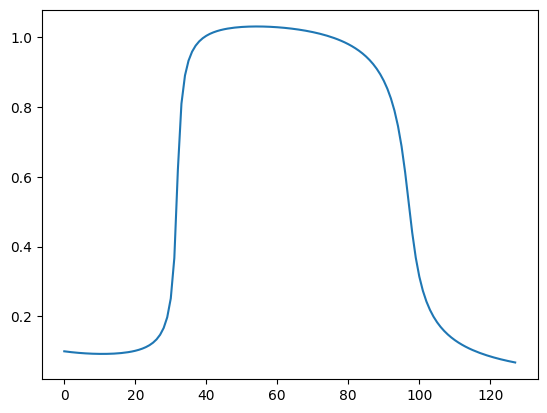

In [ ]:
trainModelduration(iterations=1000, regularize=True)
simulateModelduration()

##Train Pruned Network

In [ ]:
trainModelduration(iterations=1000, prune=True)
simulateModelduration()